In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import scipy as sp

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from string import digits


from gensim.models import Word2Vec

import random
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_error
import sys
from sklearn.preprocessing import normalize

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Леонид\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Леонид\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Леонид\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [93]:
X_train_df = pd.read_csv('X_train.csv')

In [3]:
X_train_df.head()

,title,body
0,Saving on a Model that has foreign and M2M rel...,"<p>I have 3 models, say, Fruits, Season, and F..."
1,Internal Server Error Exception from Facebook ...,"<p>I am trying to fetch campaign,ad level info..."
2,Categories/Tagging: Pull data from all Custom ...,<p>I have built a website with four custom pos...
3,Organizing an appointment with a doctor,<p>I am very new to coding and I have been wor...
4,Unable to store value of fgetc(),<p>I am trying to create a program that takes ...


In [4]:
y_train_df = pd.read_csv('Y_train.csv')

In [5]:
y_train_df.head()

,name
0,python django
1,java
2,wordpress
3,python python-3.x
4,c


### Feature analysis


In [6]:
y_list = list(y_train_df['name'])

In [7]:
words_dict = defaultdict(int)

In [8]:
for elem in y_list:
    word_list = elem.split(" ")
    for word in word_list:
        words_dict[word]+=1
print("Количество тегов: ", len(words_dict))

Количество тегов:  69


In [9]:
ordered_words_dict = OrderedDict(sorted(words_dict.items()))

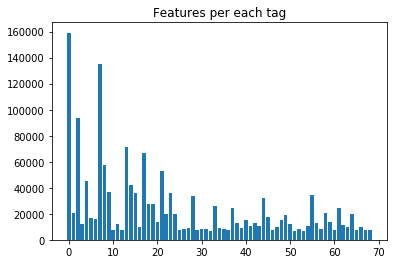

In [10]:
tags_list = words_dict.keys()
y_pos = np.arange(len(tags_list))
qunt_per_tag_list = words_dict.values()

plt.bar(y_pos, qunt_per_tag_list, align='center', alpha=1)
plt.title('Features per each tag')

plt.show()

In [11]:
tags_count_dict = defaultdict(int)

In [12]:
for elem in y_list:
    l = len(elem.split(" "))
    tags_count_dict[l]+=1

In [13]:
ordered_tags_count_dict = OrderedDict(sorted(tags_count_dict.items()))

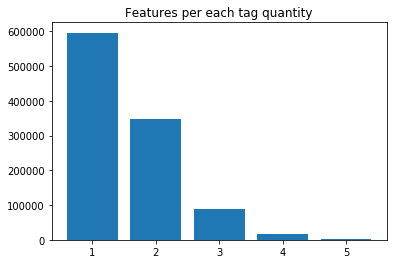

In [14]:
lens = ordered_tags_count_dict.keys()
y_pos = np.arange(5)
qunt_per_tag_list = ordered_tags_count_dict.values()

plt.bar(y_pos+1, qunt_per_tag_list, align='center', alpha=1)
plt.title('Features per each tag quantity')

plt.show()

In [15]:
top_tags_dict = sorted(ordered_words_dict.items(), key=lambda x: x[1])[::-1]

### Tags list to binary vectors

In [17]:
srt_tags_list = list(ordered_words_dict.keys())

In [18]:
y_train_vec = []
for sample in y_list:
    words_list = sample.split(" ")
    vec_sample = {key:0 for key in srt_tags_list}
    for word in words_list:
        vec_sample[word] = 1
    y_train_vec.append(list(vec_sample.values()))

### Feautures cleaning

In [87]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    
    text_no_num = re.sub(r'[0-9]+', '', text)
    
    text_no_sym = re.sub(r'!”#$%&’()*,-./:;<=>?@\^_`{|}~', '',text_no_num)
    
    text_no_html = BeautifulSoup(text_no_sym, "lxml").text
    
    text_no_whtspc = text_no_html.strip()
    
    tokens = word_tokenize(text_no_whtspc)
    
    tokens_no_stpwrd = [i for i in tokens if not i in stop_words and len(i) > 2]
    
    result = [lemmatizer.lemmatize(t) for t in tokens_no_stpwrd]
    
    return result

In [94]:
X_train_df['title'] = X_train_df['title'].apply(preprocess)

D:\Anacondas\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'how to match from  to . given version/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Anacondas\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'cassandra-. connection from spring boot ../..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Anacondas\lib\site-packages\bs4\__init__.py:273: UserWarning: "b' request entity too large nginx/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Anacondas\lib\site-packages\bs4\__init__.py:273: UserWarning: "b' bad gateway nginx/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % 

In [119]:
data = []
for sample in X_train_df['title']:
    if len(sample) != 0:
        data.append(sample)

In [127]:
y_data = []
for i, sample in enumerate(X_train_df['title']):
    if len(sample) != 0:
        y_data.append(y_train_vec[i])

In [120]:
model = Word2Vec(data, size=64, window=3, min_count=5, iter=5)

In [121]:
len(model.wv.vocab)

28077

In [123]:
def encode(tokens_list):
    x = np.array([model.wv[token] for token in tokens_list if token in model.wv.vocab])
    return (np.mean(x, axis=0)).tolist()

fts = [encode(tokens_list) for tokens_list in data]

In [124]:
print(len(fts), len(fts[0]))

1047847 64


### Validation and training

In [151]:
X_data = []
Y_data = []
for i,sample in enumerate(fts):
    if type(sample) == list:
        X_data.append(sample)
        Y_data.append(y_data[i])

In [154]:
X_data = sp.sparse.csr_matrix(X_data)
Y_data = sp.sparse.csr_matrix(Y_data)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1)

In [157]:
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [160]:
# accuracy
print('Test\n', classification_report(y_test, predictions))

Test
               precision    recall  f1-score   support

           0       0.05      0.30      0.09      1043
           1       0.10      0.69      0.17       797
           2       0.11      0.75      0.20      1255
           3       0.31      0.67      0.42      6670
           4       0.24      0.59      0.34      3655
           5       0.16      0.73      0.27       724
           6       0.07      0.68      0.12       747
           7       0.11      0.76      0.20      2041
           8       0.07      0.38      0.11       955
           9       0.08      0.60      0.15       878
          10       0.09      0.50      0.15       687
          11       0.11      0.79      0.20      1026
          12       0.12      0.70      0.21       838
          13       0.10      0.54      0.17      1689
          14       0.31      0.24      0.27      7194
          15       0.17      0.63      0.27      3362
          16       0.25      0.81      0.39      3429
          17       0.

D:\Anacondas\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [ ]:
classifier = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

D:\Anacondas\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anacondas\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anacondas\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anacondas\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anacondas\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anacondas\lib\site-packages